测试R语言回归

# 回归

先查看一下使用的数据集State.x77

In [1]:
states <- as.data.frame(state.x77[, c("Murder", "Population"
                                      , "Illiteracy", "Income", "Frost")]) 
states

               Murder Population Illiteracy Income Frost
Alabama          15.1       3615        2.1   3624    20
Alaska           11.3        365        1.5   6315   152
Arizona           7.8       2212        1.8   4530    15
Arkansas         10.1       2110        1.9   3378    65
California       10.3      21198        1.1   5114    20
Colorado          6.8       2541        0.7   4884   166
Connecticut       3.1       3100        1.1   5348   139
Delaware          6.2        579        0.9   4809   103
Florida          10.7       8277        1.3   4815    11
Georgia          13.9       4931        2.0   4091    60
Hawaii            6.2        868        1.9   4963     0
Idaho             5.3        813        0.6   4119   126
Illinois         10.3      11197        0.9   5107   127
Indiana           7.1       5313        0.7   4458   122
Iowa              2.3       2861        0.5   4628   140
Kansas            4.5       2280        0.6   4669   114
Kentucky         10.6       338

做一个简单的线性回归

In [2]:
myfit <- lm(Murder~Population+Illiteracy+Income+Frost, data=states)
summary(myfit)


Call:
lm(formula = Murder ~ Population + Illiteracy + Income + Frost, 
    data = states)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.7960 -1.6495 -0.0811  1.4815  7.6210 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.235e+00  3.866e+00   0.319   0.7510    
Population  2.237e-04  9.052e-05   2.471   0.0173 *  
Illiteracy  4.143e+00  8.744e-01   4.738 2.19e-05 ***
Income      6.442e-05  6.837e-04   0.094   0.9253    
Frost       5.813e-04  1.005e-02   0.058   0.9541    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.535 on 45 degrees of freedom
Multiple R-squared:  0.567,	Adjusted R-squared:  0.5285 
F-statistic: 14.73 on 4 and 45 DF,  p-value: 9.133e-08


看得出来$R^2$较小，可能确实一些项，检验一下LINE假设、多重共线性、以及离群点。

# 标准方法检验假定

简单用下plot，看看情况。

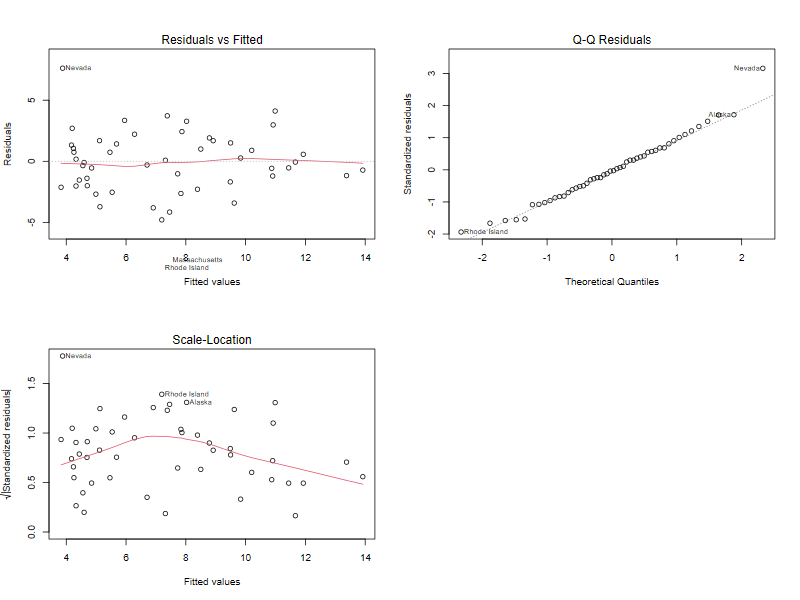

In [4]:
# 简单用一下plot
par(mfrow=c(2, 2))
plot(myfit)

Positron有点问题，使用组合图形不管是par()还是layout()都会显示不全，要显示全只能用Rstudio做，下面是完整的图：
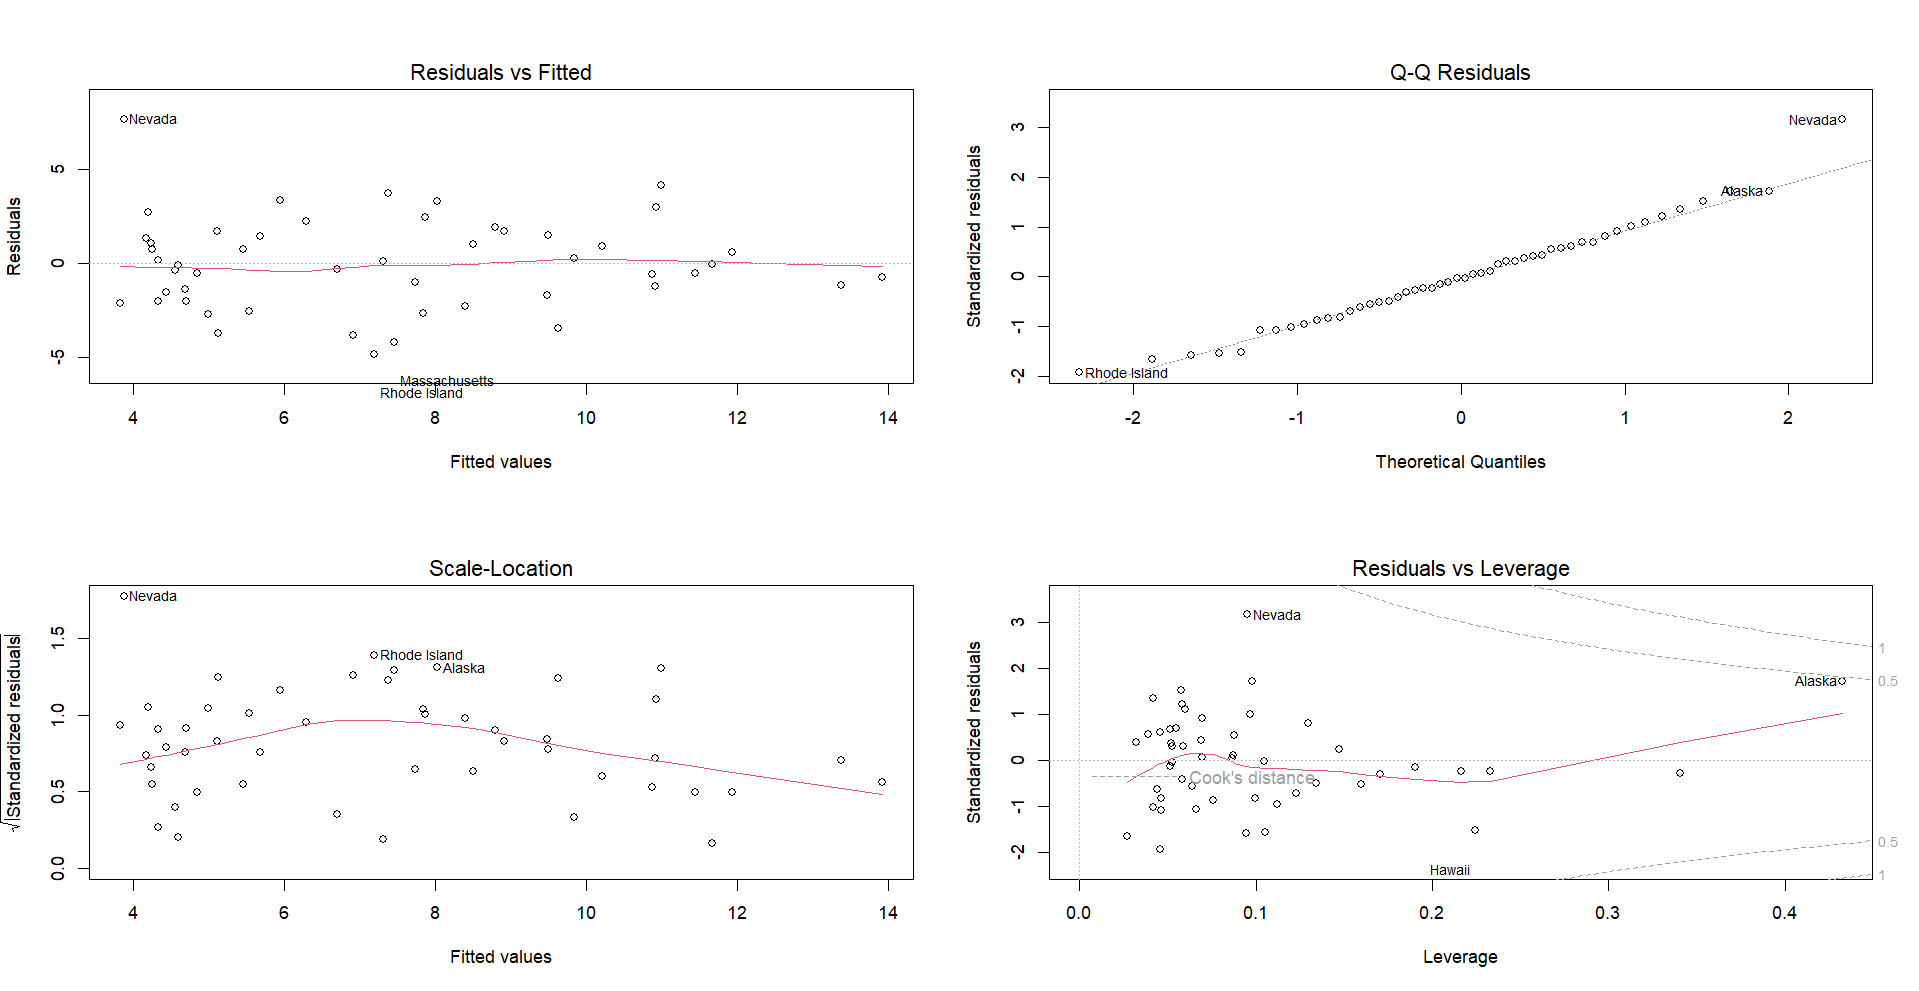

* L：从残差图与拟合图（左上）来看，基本是一个直线关系，可以认为符合线性假定。
* I：这上面四张图是不能判断独立性假设，独立性的问题在计量中应该叫自相关问题。
* N：从QQ图来看，散点基本分布在直线上，可以认为符合正态性假定，但是需要注意Nevada这个点，这是个离群点。
* E：从位置尺度图来看好像点是随机分布的，可以认为符合等方差假定。
因此，简单看了一下，LINE假定是满足的。

从残差杠杆图来看，好像存在高杠杆值点，有强影响点Alaska，有离群点Nevada。

# 检验正态性假定

进行更加细致的判定，先使用QQ图判断一下正态性，同时观察一下有没有离群点。

In [10]:
library(carData)
library(car)
qqplot(myfit, labels=row.names(states), id.method="identify",, main="Q-Q Plot", simulate=TRUE)

: [1m[33mError[39m in `rank()`:[22m
[33m![39m 类型'list'目前没有在'greater'里实现

Positron的jupter notebook跑不出来，放一张普通R跑的图：

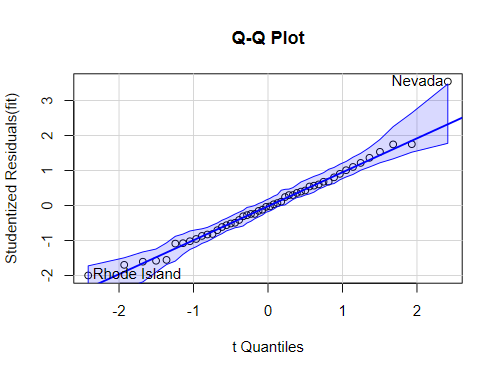

大部分点都离直线很近，除了Nevada，可以认为满足正态分布假定。蛮有意思，如果模型拟合的很好，那么残差相当于是一个正态分布，QQ图相当于是要求残差分布分位数和正态分布范围数相同，给出置信区间，如果超过直线区间，可以认为不满足正态分布，也就是说模型无法解释这一个点。而学生化残差相当于做了一个标准化，我们可以认为残差分布的方差是1，而正态分布的95%分位数是1.96，所以当残差大于2时，我们可以近似认为这是一个离群点。

# 检验独立性假定

残差的相关性可以用Durbin-Watson检验进行检验。

In [11]:
durbinWatsonTest(myfit)

 lag Autocorrelation D-W Statistic p-value
   1      -0.2006929      2.317691   0.292
 Alternative hypothesis: rho != 0

**p值不显著（p=0.282）说明无自相关性，误差项之间独立。** 滞后项（lag=1）表明数据集中每个数据都是与其后一个数据进行比较的。该检验适用于时间独立的数据，对于非聚集型的数据并不适用。

# 检验线性假定

用偏残差图检验一下线性假定：

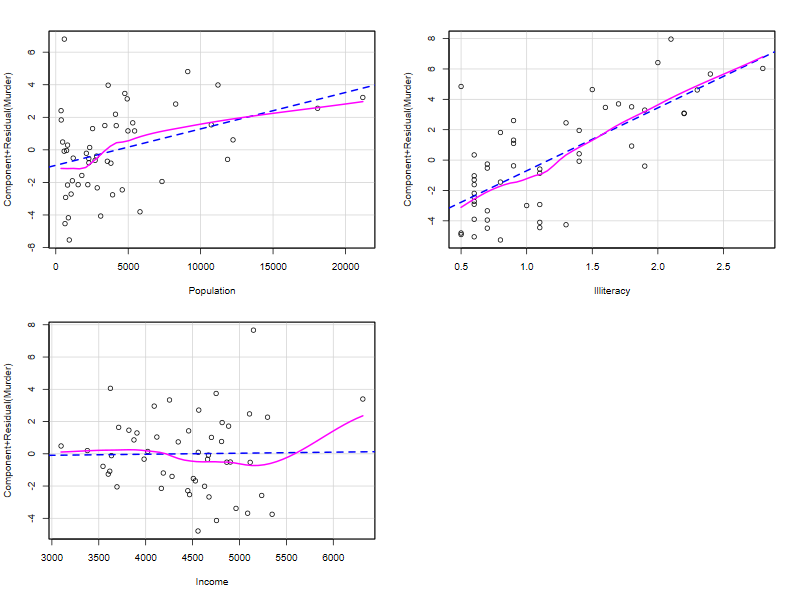

In [14]:
library(car)
crPlots(myfit)

Positron显示不全，用Rstudio画一下：

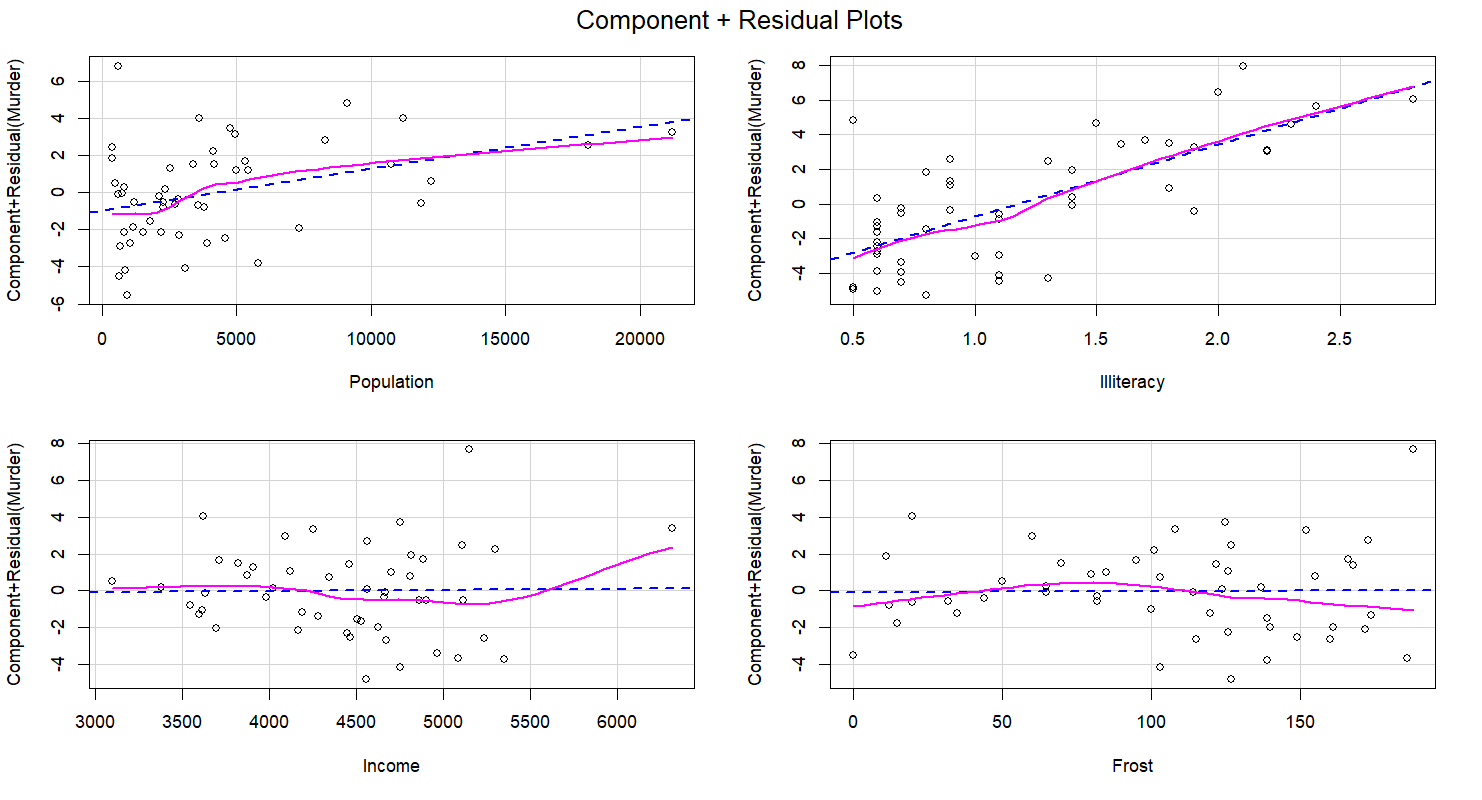

从成分残差图来看，基本证实了我们的线性假定。

# 验证同方差假定

使用`ncvTest()`检验同方差性：

In [16]:
library(car)
ncvTest(myfit)

Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 1.746514, Df = 1, p = 0.18632

计分检验不显著（p=0.19），说明满足方差不变假设。

`spreadLevelPlot()`函数创建一个添加了最佳拟合曲线的散点图，展示标准化残差绝对值与拟合值的关系。

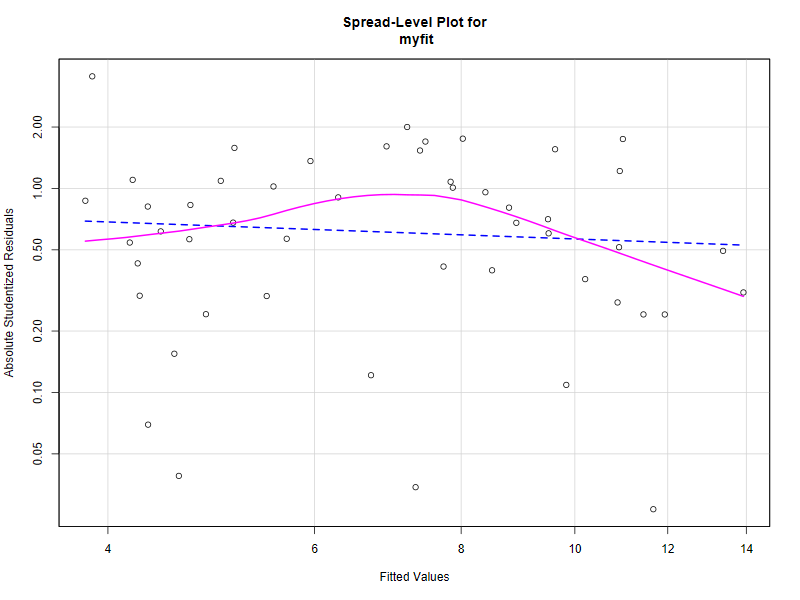


Suggested power transformation:  1.209626 

In [18]:
library(car)
par(mfrow=c(1, 1))
spreadLevelPlot(myfit)

# 检验多重共线性

通过方差膨胀因子(VIF)检验一下多重共线性：

In [19]:
library(car)
vif(myfit)

Population Illiteracy     Income      Frost 
  1.245282   2.165848   1.345822   2.082547 

In [20]:
sqrt(vif(myfit)) > 2

Population Illiteracy     Income      Frost 
     FALSE      FALSE      FALSE      FALSE 

# 检验离群点

In [22]:
library(car)
outlierTest(myfit)

       rstudent unadjusted p-value Bonferroni p
Nevada 3.542929         0.00095088     0.047544

你可以看到Nevada被判定为离群点（p=0.048）。注意，该函数只是根据单个最大（或正或负）残差值的显著性来判断是否有离群点。若不显著，则说明数据集中没有离群点；若显著，则你必须删除该离群点，然后再检验是否还有其他离群点存

# 检验高杠杆值点

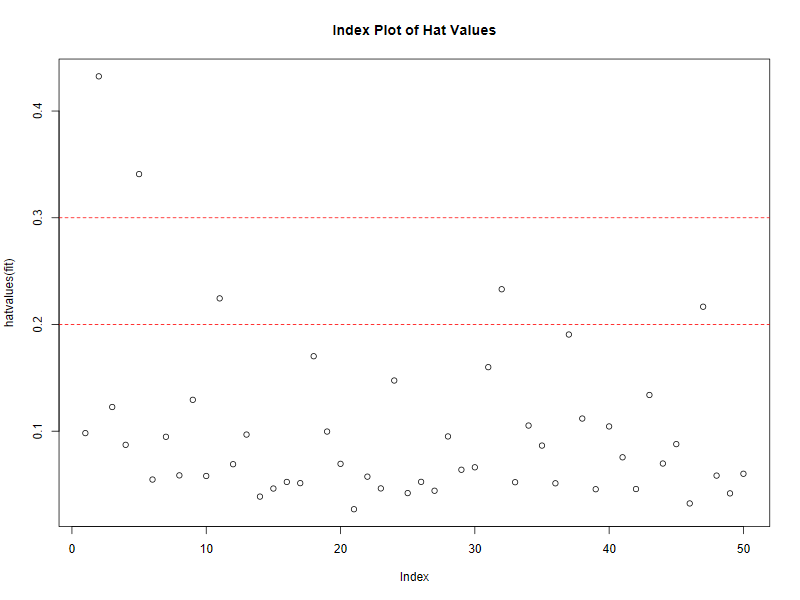

integer(0)

In [24]:
hat.plot <- function(fit){
  p <-  length(coefficients(fit))
  n <- length(fit$residuals)
  plot(
    hatvalues(fit),
    main="Index Plot of Hat Values",
  )
  abline(
    h=c(2, 3)*p/n,
    col="red",
    lty=2
  )
  identify(
    1:n,
    hatvalues(fit),
    names(hatvalues(fit))
  )
}

hat.plot(myfit)

# 强影响点

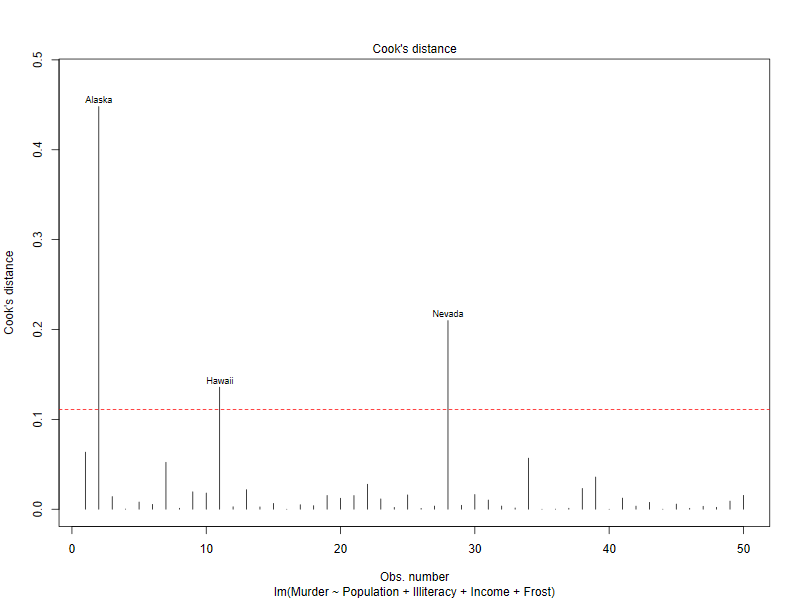

In [37]:
cutoff <- 4/(nrow(states)-length(myfit)-2)
plot(myfit, which=4, cook.levels=cutoff)
abline(h=cutoff, lty=2, col="red")

测试变量添加图：

共有28个警告 (用warnings()来显示)


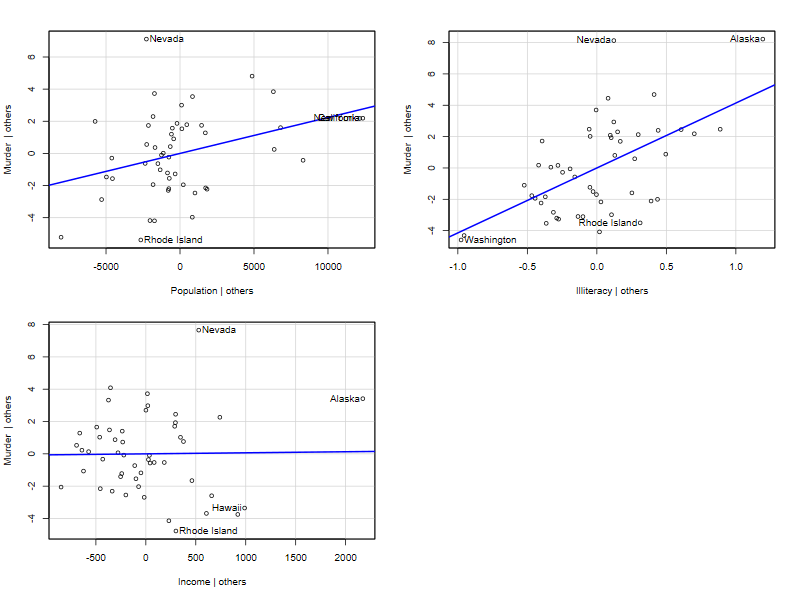

In [39]:
library(car)
avPlots(myfit, ask=FALSE, id.method="identity")

显示不全，完整的结果如下：
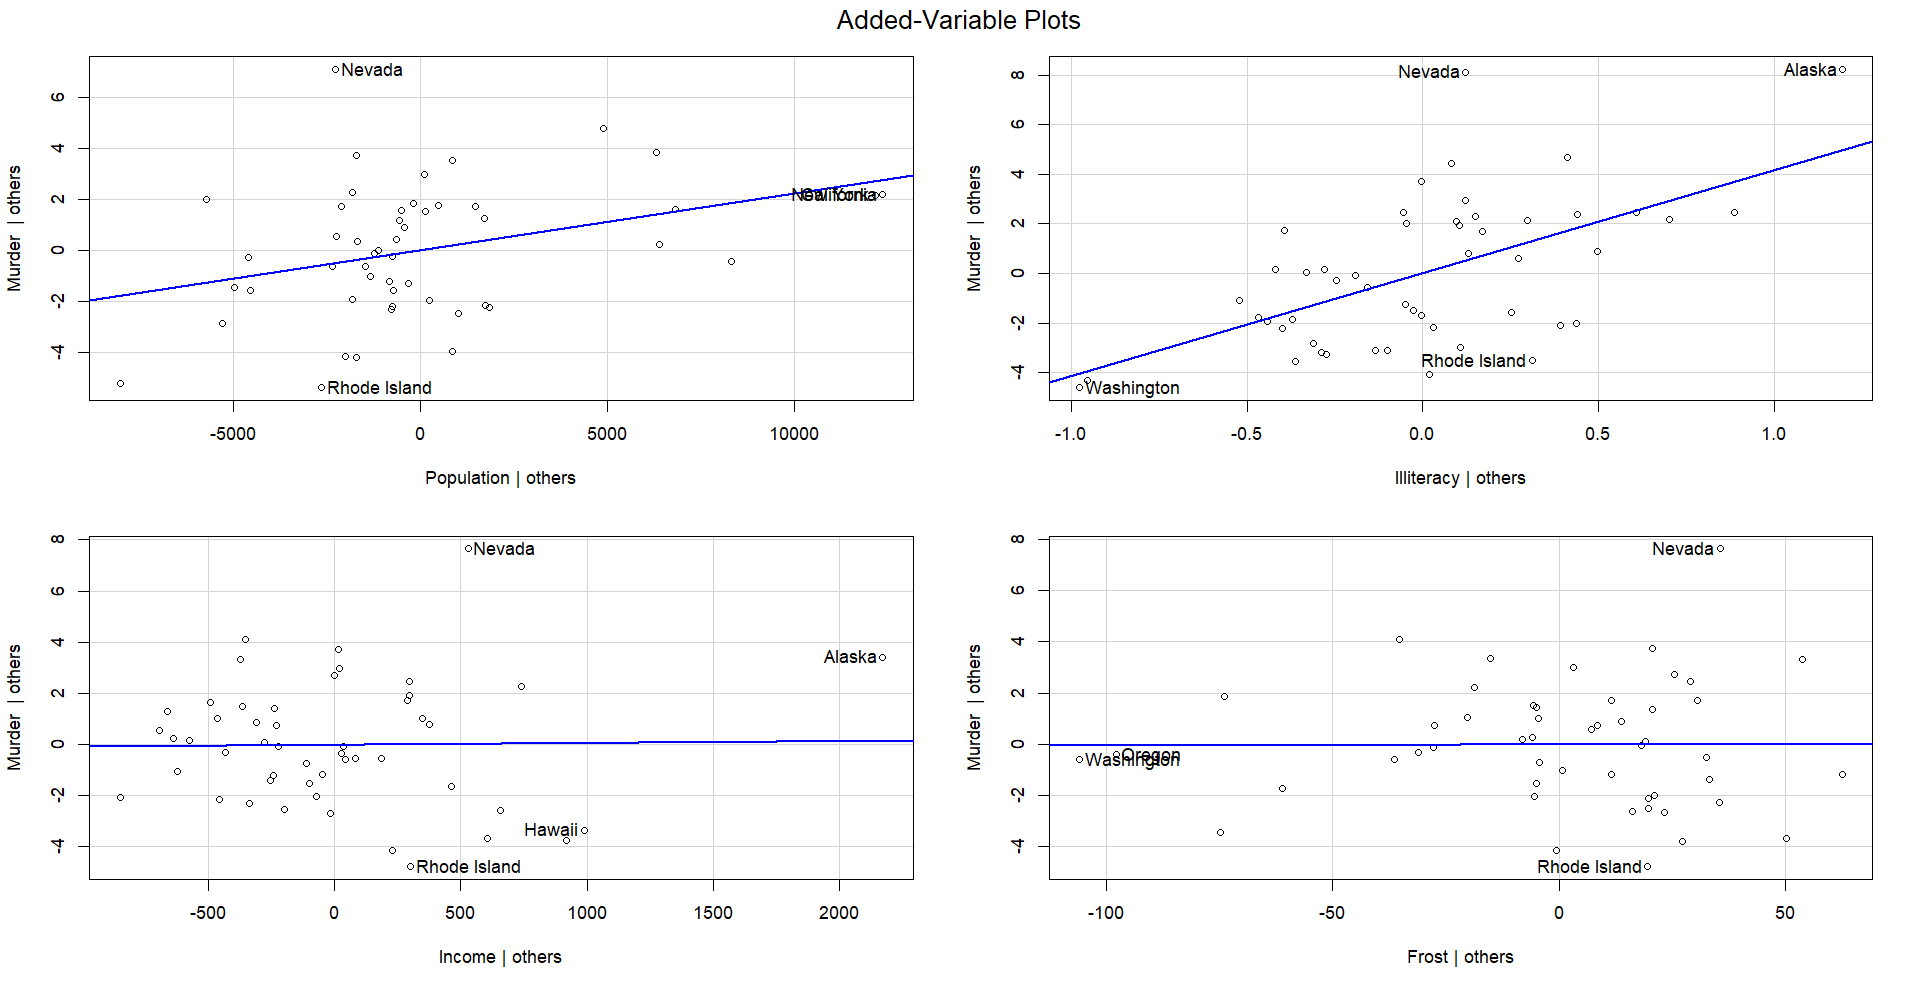

绘制影响图：

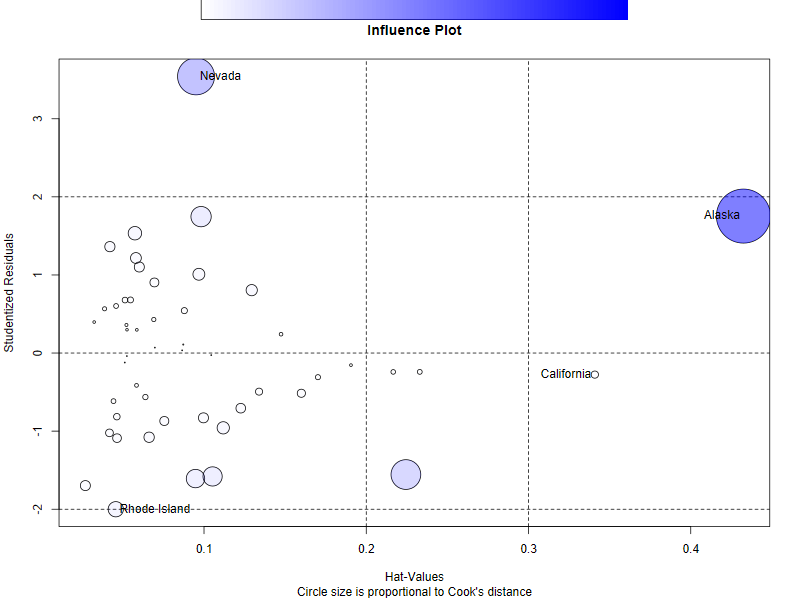

                StudRes        Hat       CookD
Alaska        1.7536917 0.43247319 0.448050997
California   -0.2761492 0.34087628 0.008052956
Nevada        3.5429286 0.09508977 0.209915743
Rhode Island -2.0001631 0.04562377 0.035858963

In [41]:
states <- as.data.frame(state.x77[, c("Murder", "Population",
                                      "Illiteracy", "Income", "Frost")])
fit <- lm(Murder~Population+Illiteracy+Income+Frost, data=states)

library(car)
influencePlot(fit, main="Influence Plot",
              sub="Circle size is proportional to Cook's distance")

In [42]:
states <- as.data.frame(state.x77[, c("Murder", "Population",
                                      "Illiteracy", "Income", "Frost")])
fit <- lm(Murder~Population+Illiteracy+Income+Frost, data=states)

library(car)
summary(powerTransform(states$Murder)) 

bcPower Transformation to Normality 
              Est Power Rounded Pwr Wald Lwr Bnd Wald Upr Bnd
states$Murder    0.6055           1       0.0884       1.1227

Likelihood ratio test that transformation parameter is equal to 0
 (log transformation)
                           LRT df     pval
LR test, lambda = (0) 5.665991  1 0.017297

Likelihood ratio test that no transformation is needed
                           LRT df    pval
LR test, lambda = (1) 2.122763  1 0.14512

In [43]:
states <- as.data.frame(state.x77[, c("Murder", "Population",
                                      "Illiteracy", "Income", "Frost")])
fit <- lm(Murder~Population+Illiteracy+Income+Frost, data=states)

library(car)
boxTidwell(Murder~Population+Illiteracy, data=states)

           MLE of lambda Score Statistic (t) Pr(>|t|)
Population       0.86939             -0.3228   0.7483
Illiteracy       1.35812              0.6194   0.5388

iterations =  19 

Score test for null hypothesis that all lambdas = 1:
F = 0.23214, df = 2 and 45, Pr(>F) = 0.7938


# 选择最优模型

In [44]:
states <-  as.data.frame(state.x77[, c("Murder", "Population", "Illiteracy", "Income", "Frost")])

fit1 <- lm(Murder~Population+Illiteracy+Income+Frost, data=states)
fit2 <- lm(Murder~Population+Illiteracy, data=states)

anova(fit1, fit2)

Analysis of Variance Table

Model 1: Murder ~ Population + Illiteracy + Income + Frost
Model 2: Murder ~ Population + Illiteracy
  Res.Df    RSS Df Sum of Sq      F Pr(>F)
1     45 289.17                           
2     47 289.25 -2 -0.078505 0.0061 0.9939

In [45]:
states <-  as.data.frame(state.x77[, c("Murder", "Population", "Illiteracy", "Income", "Frost")])

fit1 <- lm(Murder~Population+Illiteracy+Income+Frost, data=states)
fit2 <- lm(Murder~Population+Illiteracy, data=states)

AIC(fit1, fit2)

     df      AIC
fit1  6 241.6429
fit2  4 237.6565

# 变量选择

In [73]:
# 向后回归
library(MASS)

states <-  as.data.frame(state.x77[, c("Murder", "Population", "Illiteracy", "Income", "Frost")])
fit <- lm(Murder~Population+Illiteracy+Income+Frost, data=states)

stepAIC(fit, direction="forward")

Start:  AIC=97.75
Murder ~ Population + Illiteracy + Income + Frost




Call:
lm(formula = Murder ~ Population + Illiteracy + Income + Frost, 
    data = states)

Coefficients:
(Intercept)   Population   Illiteracy       Income        Frost  
  1.235e+00    2.237e-04    4.143e+00    6.442e-05    5.813e-04  


In [58]:
# 加载 mtcars 数据集
data(mtcars)

# 创建一个仅包含截距的初始模型
initial_model <- lm(mpg ~ 1, data = mtcars)

# 使用 stepAIC 进行向前选择
stepAIC(initial_model, 
                       scope=list(upper=~. , lower=~1), 
                       direction="forward", 
                       trace=TRUE)

Start:  AIC=115.94
mpg ~ 1




Call:
lm(formula = mpg ~ 1, data = mtcars)

Coefficients:
(Intercept)  
      20.09  


In [78]:
# 向前回归
library(MASS)

states <-  as.data.frame(state.x77[, c("Murder", "Population", "Illiteracy", "Income", "Frost")])
null_model <- lm(Murder ~ 1, data = states)
full_model <- lm(Murder ~ ., data = states)

stepAIC(null_model, scope = list(lower = null_model, upper = full_model), direction = "forward", trace = TRUE)

Start:  AIC=131.59
Murder ~ 1

             Df Sum of Sq    RSS     AIC
+ Illiteracy  1    329.98 337.76  99.516
+ Frost       1    193.91 473.84 116.442
+ Population  1     78.85 588.89 127.311
+ Income      1     35.35 632.40 130.875
<none>                    667.75 131.594

Step:  AIC=99.52
Murder ~ Illiteracy

             Df Sum of Sq    RSS     AIC
+ Population  1    48.517 289.25  93.763
<none>                    337.76  99.516
+ Frost       1     5.387 332.38 100.712
+ Income      1     4.916 332.85 100.783

Step:  AIC=93.76
Murder ~ Illiteracy + Population

         Df Sum of Sq    RSS    AIC
<none>                289.25 93.763
+ Income  1  0.057022 289.19 95.753
+ Frost   1  0.021447 289.22 95.759



Call:
lm(formula = Murder ~ Illiteracy + Population, data = states)

Coefficients:
(Intercept)   Illiteracy   Population  
  1.6515497    4.0807366    0.0002242  


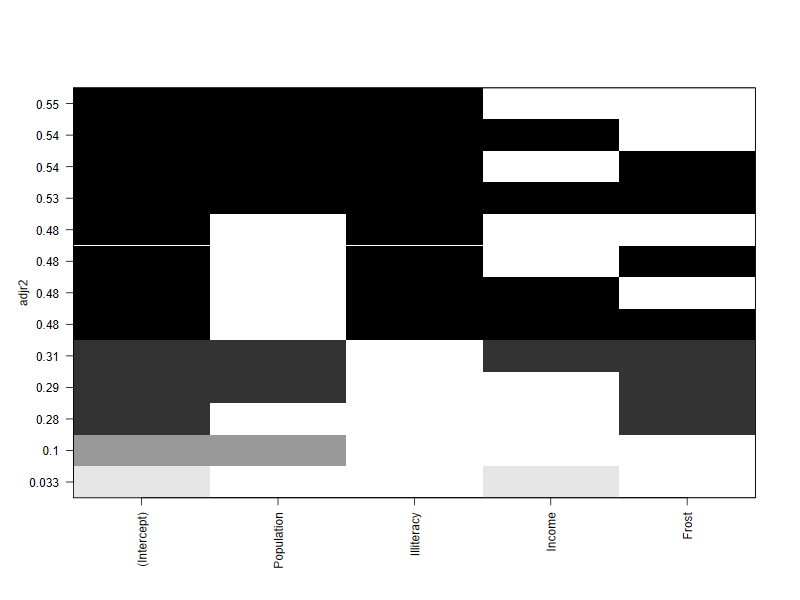

In [79]:
library(leaps)

states <-  as.data.frame(state.x77[, c("Murder", "Population", "Illiteracy", "Income", "Frost")])
leaps <- regsubsets(Murder~Population+Illiteracy+Income+Frost, data=states, nbest=4)
plot(leaps, scale="adjr2")

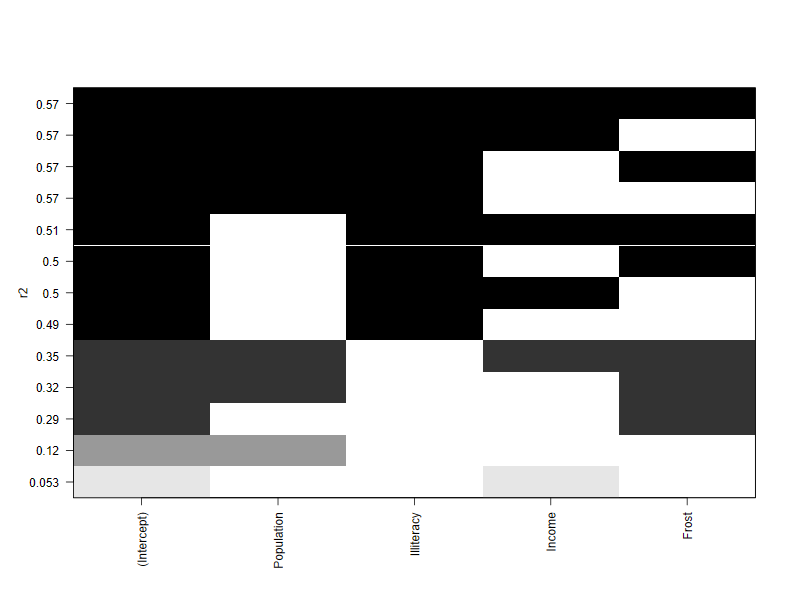

In [81]:
plot(leaps, scale="r2")

Error in legend(if (!is.na(charmatch(legend[1], "interactive"))) locator(1) else if (is.character(legend)) legend else if (is.numeric(legend) &&  : 
  座标长度无效


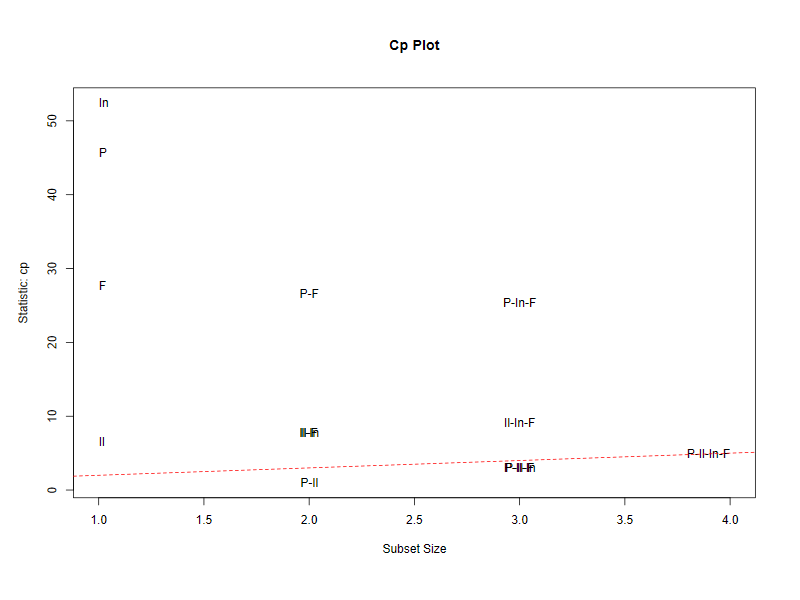

In [89]:
library(car)

try(subsets(leaps, statistic="cp", main="Cp Plot"))
abline(a=1, b=1, lty=2, col="red")

# k折验证

In [98]:
shrinkage <- function(fit, k=10){
  library(bootstrap)
  theta.fit <- function(x, y){
    lsfit(x, y)
  }
  theta.predict <- function(fit, x){
    cbind(1, x)%*%fit$coef
  }
  x <- fit$model[,2:ncol(fit$model)]
  y <- fit$model[,1]
  results <- crossval(x, y, theta.fit, theta.predict, ngroup=k)
  r2 <- cor(y, fit$fitted.values)^2
  r2cv <- cor(y, results$cv.fit)^2
  cat("Original R^2:", r2, "\n")
  cat("Cross-validated R^2:", r2cv, "\n")
  cat("Change=", r2-r2cv, "\n")
}

In [100]:
fit1 <- lm(Murder~Population+Illiteracy+Income+Frost, data=states)
shrinkage(fit1)

Original R^2: 0.5669502 
Cross-validated R^2: 0.4683278 
Change= 0.09862243 


In [99]:
fit2 <- lm(Murder~Population+Illiteracy, data=states)
shrinkage(fit2)

Original R^2: 0.5668327 
Cross-validated R^2: 0.5199385 
Change= 0.04689418 


# 相对重要性

In [10]:
states <- as.data.frame(state.x77[, c("Murder", "Population", "Illiteracy", "Income", "Frost")])
class(scale(states))

[1] "matrix" "array" 

In [11]:
zstates <- as.data.frame(scale(states))
zfit <- lm(Murder~Population+Illiteracy+Income+Frost, data=zstates)
coef(zfit)

  (Intercept)    Population    Illiteracy        Income         Frost 
-2.054026e-16  2.705095e-01  6.840496e-01  1.072372e-02  8.185407e-03 

In [31]:
relweights <- function(fit) {
  # 检查数据格式
  if (!all(sapply(fit$model, is.numeric))) {
    stop("All variables in the model must be numeric.")
  }
  
  # 计算相关系数矩阵
  R <- cor(fit$model)
  nvar <- ncol(R)
  rxx <- R[2:nvar, 2:nvar]  # 自变量的相关系数矩阵
  rxy <- R[2:nvar, 1]       # 自变量与因变量的相关系数
  
  # 特征值分解
  svd <- eigen(rxx)
  evec <- svd$vectors  # 特征向量
  ev <- svd$values     # 特征值
  
  # 计算 lambda 矩阵
  delta <- diag(sqrt(ev))
  lambda <- evec %*% delta %*% t(evec)
  lambdasq <- lambda^2
  
  # 计算 beta 系数
  beta <- solve(lambda) %*% rxy
  
  # 计算 R²
  rsquare <- colSums(beta^2)
  
  # 计算原始权重
  rawwgt <- lambdasq %*% beta^2
  
  # 计算相对权重
  import <- (rawwgt / rsquare) * 100
  import <- as.data.frame(import)
  row.names(import) <- names(fit$model)[2:nvar]
  names(import) <- "Weights"
  
  # 按权重排序
  import <- import[order(import$Weights),1 , drop = FALSE]
  
  # 绘制点图
  dotchart(
    import$Weights, 
    labels = row.names(import), 
    xlab = "% of R-Square",
    pch = 19,
    main = "Relative Importance Chart", 
    sub = paste("Total R-square =", round(rsquare, digits = 3))
  )
  
  # 返回权重数据框
  return(import)
}

In [13]:
states <- as.data.frame(state.x77[, c("Murder", "Population", "Illiteracy", "Income", "Frost")])

fit <- lm(Murder~Population+Illiteracy+Income+Frost, data=states)


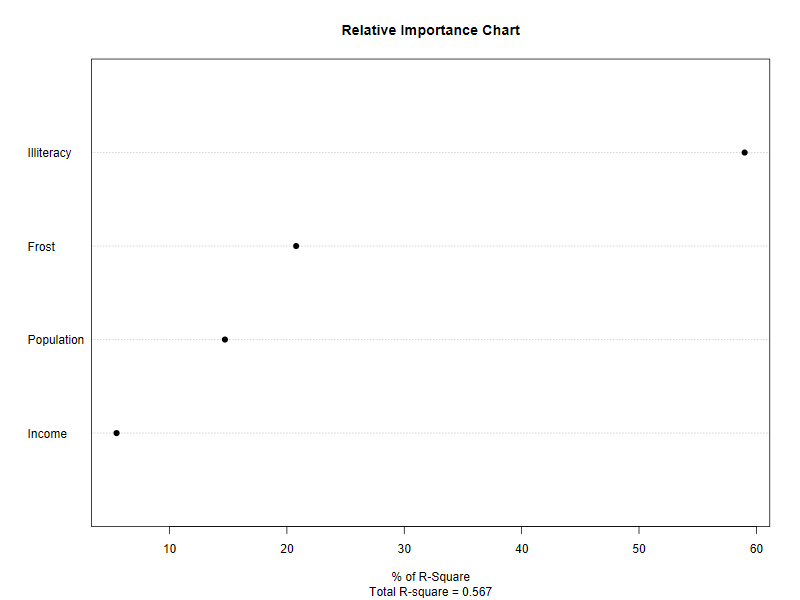

             Weights
Income      5.488962
Population 14.723401
Frost      20.787442
Illiteracy 59.000195

In [32]:
relweights(fit)